In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D,AveragePooling2D,Conv2DTranspose, Input, Concatenate, Add, BatchNormalization, Activation, MultiHeadAttention
from ipywidgets import IntProgress
from IPython.display import display
import os
import cv2
import PIL
import PIL.Image
import json
import random
from random import randint as rand
from os import listdir
from os.path import isfile, join
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
num_layers_to_keep = 154
output_tensor = base_model.layers[num_layers_to_keep - 1].output
clipped_model = tf.keras.Model(inputs=base_model.input, outputs=output_tensor)
for layer in clipped_model.layers[:50]:
    layer.trainable = False
clipped_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 7, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

In [22]:
for layer in model.base_network.layers[100:]:
    layer.trainable = True

In [4]:
import tensorflow as tf
import json
from PIL import Image

path_to_images = "C:/users/user/ai tests/autoencoder tests/datasets/train2014"
path_to_json = "C:/users/user/ai tests/autoencoder tests/datasets/annotations/instances_train2014.json"

def fill(shape, value):
    for ax in shape:
        value = tf.repeat(tf.expand_dims(value, axis = 1), ax, axis = 1)
    return value 

def IoU(boxA, boxB):
        boxes = tf.concat([tf.expand_dims(boxA, axis = 0), tf.expand_dims(boxB, axis = 0)], axis = 0)
        A = tf.reduce_max(boxes, axis = 0)
        B = tf.reduce_min(boxes, axis = 0)
        xA = A[:, 0]
        yA = A[:, 1]
        xB = B[:, 2]
        yB = B[:, 3]

        interW = tf.nn.relu(xB - xA + 1)
        interH = tf.nn.relu(yB - yA + 1)

        interArea = interW * interH
        boxAArea = (boxA[:, 2] - boxA[:, 0] + 1) * (boxA[:, 3] - boxA[:, 1] + 1)
        boxBArea = (boxB[:, 2] - boxB[:, 0] + 1) * (boxB[:, 3] - boxB[:, 1] + 1)

        iou = interArea / tf.cast(boxAArea + boxBArea - interArea, dtype=tf.float32)
        return iou


def generate_void_boxes(gt, image_size = 224, n_void = 2):
    void_boxes_center = tf.random.uniform([n_void*10, 2], minval=0, maxval = image_size)
    void_boxes_size = tf.random.uniform([n_void*10, 2], minval= 0, maxval = image_size / 2)
    void_boxes_lu = void_boxes_center - void_boxes_size
    void_boxes_rd = void_boxes_center + void_boxes_size
    void_boxes = tf.concat([void_boxes_lu, void_boxes_rd], axis = 1)
    void_boxes = tf.clip_by_value(void_boxes, 0, image_size)
    
    num_void = void_boxes.shape[0]
    num_gt = gt.shape[0]
    r_void = tf.repeat(tf.expand_dims(void_boxes, axis = 0), num_gt, axis = 0)
    r_gt = tf.tile(tf.expand_dims(gt, axis=1), multiples=[1, num_void, 1])
    r_gt = tf.reshape(r_gt, shape=[-1, num_void, 4])
    r_void = tf.reshape(r_void, [-1, 4])
    r_gt = tf.reshape(r_gt, [-1, 4])
    iou = IoU(r_void, r_gt)
    iou = tf.reshape(iou, [num_gt, num_void])
    max_iou_arg = tf.argmax(iou, axis = 0)
    corresponding_void = void_boxes
    iou_rates = tf.reduce_max(iou, axis = 0)
    indexes = tf.argsort(iou_rates, direction='ASCENDING')
    corresponding_void = tf.gather(corresponding_void, indexes)
    iou_rates = tf.gather(iou_rates, indexes)
    resulted_boxes = []
    for i in range(iou_rates.shape[0]):
        if(iou_rates[-i] < 0.3):
            resulted_boxes.append(corresponding_void[-i])
        if len(resulted_boxes) == n_void:
            break
    return tf.stack(resulted_boxes)


def preprocess_image(img_filename):
    img = tf.io.read_file(img_filename)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.cast(img, tf.float32) / 128 - 1
    return img

with open(path_to_json, 'r') as f:
    json_data = json.load(f)

image_boxes_dict = {str(annotation['image_id']): [] for annotation in json_data['annotations']}

for annotation in json_data['annotations']:
    image_boxes_dict[str(annotation['image_id'])].append([annotation['bbox'], annotation['category_id']])
    

fixed_num_boxes = 20
def generator():
    for image_id, bounding_boxes in image_boxes_dict.items():
        image_path = path_to_images + f"/COCO_train2014_{image_id.rjust(12, '0')}.jpg"
        image = preprocess_image(image_path)
        level_x =  224 / image.shape[1]
        level_y =  224 / image.shape[0]
        image = tf.image.resize(image, (224, 224), method='area')
        rescaled_boxes = []
        classes = []
        while(len(rescaled_boxes) < 20):
            for box in bounding_boxes:
                rescaled_boxes.append([box[0][0] * level_x, box[0][1] * level_y, (box[0][2]+box[0][0]) * level_x, (box[0][3]+box[0][1]) * level_y])
                classes.append([box[1]])
                if len(rescaled_boxes) == 20:
                    break
        rescaled_boxes = tf.stack(rescaled_boxes)    
        classes = tf.stack(classes)
        void_boxes =  generate_void_boxes(rescaled_boxes, n_void = 2)
        zero_classes = tf.zeros([void_boxes.shape[0], 1], dtype = tf.int32)
        classes = tf.concat([classes, zero_classes], axis = 0)
        rescaled_boxes = tf.concat([rescaled_boxes, void_boxes], axis = 0)
        yield image, rescaled_boxes, classes

dataset = tf.data.Dataset.from_generator(generator, output_signature=(tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32),
                                                                        tf.TensorSpec(shape=(None, 4), dtype=tf.float32),
                                                                        tf.TensorSpec(shape=(None, 1), dtype=tf.int32)))
dataset = dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE).shuffle(50)

In [ ]:
for data in dataset.take(1):
    pass

In [5]:
inputs = Input((3, 3, 1280))
#x = Conv2D(128, 3, activation = 'relu')(inputs)
x = inputs
x = Flatten()(x)
x = Dense(128, activation = 'relu')(x)
outputs = Dense(91, activation = 'softmax')(x)
classifier_network = keras.Model(inputs, outputs)
classifier_network.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 3, 3, 1280)]      0         
                                                                 
 flatten (Flatten)           (None, 11520)             0         
                                                                 
 dense (Dense)               (None, 128)               1474688   
                                                                 
 dense_1 (Dense)             (None, 91)                11739     
                                                                 
Total params: 1,486,427
Trainable params: 1,486,427
Non-trainable params: 0
_________________________________________________________________


In [6]:
class ClassifierModel(keras.Model):
    def __init__(self, network, base_network):
        super().__init__()
        self.network = network
        self.base_network = base_network
        self.lr = 1e-5
        self.step_counter = 0
        self.colors = tf.concat([[[0,0,0]],tf.random.uniform([90, 3], 0, 1)], axis = 0)
        self.optimizer = tf.keras.optimizers.Adam(self.lr)
        self.base_optimizer = tf.keras.optimizers.Adam(1e-5)
        self.crossentropy = tf.keras.losses.CategoricalCrossentropy()
    
    def draw_box(self, image, box, color = (255, 0, 0)):
        image = cv2.rectangle(image, 
                              (int(tf.clip_by_value(box[0], 0, 244)), int(tf.clip_by_value(box[1], 0, 244))), 
                              (int(tf.clip_by_value(box[2], 0, 244)), int(tf.clip_by_value(box[3], 0, 244))),
                              color, 1)
        return image
    def roi_pool(self, boxes, feature_map, embedding_size = 3, image_size = 224):
        feature_map_size = feature_map.shape[0] - 1
        num_filters = feature_map.shape[2]
        num_boxes = boxes.shape[0]
        scale = feature_map_size / image_size
        scaled_boxes = boxes*scale
        box_width = scaled_boxes[:, 2] - scaled_boxes[:, 0]
        box_height = scaled_boxes[:, 3] - scaled_boxes[:, 1]

        x_positions = tf.linspace(0.0, float(embedding_size - 1), embedding_size)
        y_positions = tf.linspace(0.0, float(embedding_size - 1), embedding_size)
        x_grid, y_grid = tf.meshgrid(x_positions, y_positions)
        grid_shape = x_grid.shape
        x_grid = tf.repeat(tf.expand_dims(x_grid, axis = 0), num_boxes, axis = 0)
        y_grid = tf.repeat(tf.expand_dims(y_grid, axis = 0), num_boxes, axis = 0)

        position_tensor = tf.stack([fill(grid_shape, scaled_boxes[:, 0]) + x_grid * fill(grid_shape, box_width / embedding_size),
                                    fill(grid_shape, scaled_boxes[:, 1]) + y_grid * fill(grid_shape, box_height / embedding_size),
                                    fill(grid_shape, scaled_boxes[:, 0]) + (x_grid + 1) * fill(grid_shape, box_width / embedding_size),
                                    fill(grid_shape, scaled_boxes[:, 1]) + (y_grid + 1) * fill(grid_shape, box_height / embedding_size)], axis=-1)
        cuts = tf.cast(position_tensor, dtype = tf.int32)


        shifts = tf.stack([tf.zeros(cuts.shape[:-1], dtype = tf.int32),
                           tf.zeros(cuts.shape[:-1], dtype = tf.int32),
                           tf.ones(cuts.shape[:-1], dtype = tf.int32),
                           tf.ones(cuts.shape[:-1], dtype = tf.int32)], axis = -1)
        cuts += shifts
        result = []
        for batch in range(num_boxes):
            temp1 = []
            for i in range(embedding_size):
                temp2 = []
                for j in range(embedding_size):
                    a = tf.reduce_max(feature_map[cuts[batch, j, i, 0]:cuts[batch, j, i, 2], cuts[batch, j, i, 1]:cuts[batch, j, i, 3],: ], axis = (0, 1))
                    temp2.append(a)
                temp1.append(tf.stack(temp2))
            result.append(tf.stack(temp1))
        result = tf.stack(result)

        return result
    
    def testing(self):
        for data in dataset.take(1):
            image, bounding_boxes, classes = data
        
        image = tf.expand_dims(image, axis=0)
        feature_map = self.base_network(image)
        rois = self.roi_pool(bounding_boxes, feature_map[0])
        pred_probs = self.network(rois)
        print(pred_probs)
        pred_classes = tf.argmax(pred_probs, axis = 1)
        print(classes[:, 0])
        print(pred_classes)
        image = ((image+1)/2).numpy()[0]
        for box_n in range(bounding_boxes.shape[0]):
            r = float(self.colors[pred_classes[box_n]].numpy()[0])
            g = float(self.colors[pred_classes[box_n]].numpy()[1])
            b = float(self.colors[pred_classes[box_n]].numpy()[2])
            image = self.draw_box(image, bounding_boxes[box_n], color = (r, g, b))
        plt.imshow(image)
    @tf.function    
    def train_step(self, image, bounding_boxes, classes):
        image = tf.expand_dims(image, axis=0)
        classes = classes[:, 0]
        with tf.GradientTape() as tape, tf.GradientTape() as base_tape:
            feature_map = self.base_network(image, training=True)
            rois = self.roi_pool(bounding_boxes, feature_map[0])
            pred_probs = self.network(rois, training=True)
            gt_probs = tf.one_hot(classes, 91)
            loss = self.crossentropy(gt_probs, pred_probs)
        gradients = tape.gradient(loss, self.network.trainable_variables)
        base_gradients = base_tape.gradient(loss, self.base_network.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.network.trainable_variables))
        self.base_optimizer.apply_gradients(zip(base_gradients, self.base_network.trainable_variables))
        return loss
    
    def nothing(self, image, bounding_boxes, classes):
        image = tf.expand_dims(image, axis=0)
        feature_map = self.base_network(image, training=False)
        plt.imshow(feature_map[0, :, :, 0:3])
        plt.show()
        classes = classes[:, 0]
        plt.imshow((image[0]+1)/2)
        plt.show()
        print(classes)
        rois = self.roi_pool(tf.cast([[0,0,112,112]], dtype = tf.float32), feature_map[0])
        plt.imshow(rois[0, :, :, 0:3])
        plt.show()
        
model = ClassifierModel(classifier_network, clipped_model)

In [ ]:
model.testing()

эпоха 0
ошибка: 1.6379919052124023


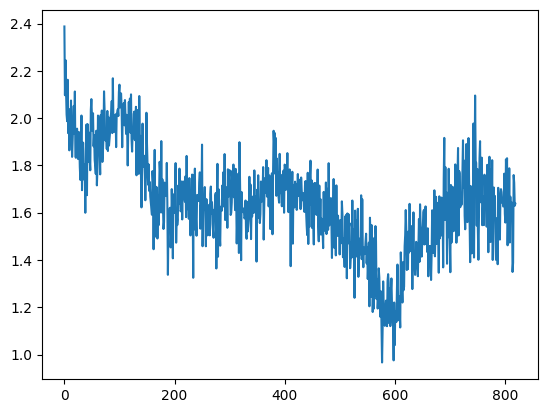

In [94]:
#обучаем
epochs = 1
hist = np.array(np.empty([0]))
best_loss = 100000
from IPython.display import clear_output
for epoch in range(epochs):
    midloss = 0
    for step, x in enumerate(dataset):
        
        image, bounding_boxes, classes = x
        loss = model.train_step(image, bounding_boxes, classes)
           
        midloss += loss
        if(step % 100 == 99):  
            clear_output(wait=True)
            print('эпоха ' + str(epoch))
            print('ошибка: ' + str(float(midloss/100)))
           
            hist = np.append(hist, float(midloss/100))
            plt.plot(np.arange(0,len(hist)), hist)
            plt.show()
            if (midloss/100 < best_loss):
                best_loss = midloss/100
                model.network.save('b_classifier.h5')
                model.base_network.save('b_base_classifier.h5')
            midloss = 0
         #   
          #  model.testing(test_img, only_true = True)
          #  plt.show()

In [ ]:
for x in dataset.take(1):
        image, bounding_boxes, classes = x
        model.nothing(image, bounding_boxes, classes)
        

In [120]:
model.network.save('classifier.h5')
model.base_network.save('base_classifier.h5')

In [8]:
model.network.load_weights('classifier.h5')
model.base_network.load_weights('base_classifier.h5')